# Análise perfil abstenção e comparecimento - Eleições 2022 1º Turno

## Objetivo

Analisar qual o perfil dos eleitores que compareceram versus os que abstiveram 

## Preparação dos dados

Importações

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



from sklearn import set_config
set_config(print_changed_only=False)

Leitura dos dados eleitores

In [3]:
tb_eleicoes = pd.read_csv("perfil_comparecimento_abstencao_2022.csv",encoding="cp1252",sep=';')

In [4]:
tb_eleicoes = tb_eleicoes[['SG_UF','NM_MUNICIPIO', 'DS_GENERO', 'DS_FAIXA_ETARIA',
          'DS_GRAU_ESCOLARIDADE', 'QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCAO',
            'QT_COMPARECIMENTO_DEFICIENCIA','QT_ABSTENCAO_DEFICIENCIA','QT_COMPARECIMENTO_TTE','QT_ABSTENCAO_TTE']]
tb_eleicoes.head()

,SG_UF,NM_MUNICIPIO,DS_GENERO,DS_FAIXA_ETARIA,DS_GRAU_ESCOLARIDADE,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCAO,QT_COMPARECIMENTO_DEFICIENCIA,QT_ABSTENCAO_DEFICIENCIA,QT_COMPARECIMENTO_TTE,QT_ABSTENCAO_TTE
0,AP,PRACUÚBA,MASCULINO,40 a 44 anos,ENSINO FUNDAMENTAL COMPLETO,10,7,3,0,0,0,0
1,AP,PRACUÚBA,MASCULINO,65 a 69 anos,ENSINO FUNDAMENTAL COMPLETO,2,2,0,0,0,0,0
2,AP,PRACUÚBA,MASCULINO,75 a 79 anos,ANALFABETO,2,0,2,0,0,0,0
3,AP,PRACUÚBA,MASCULINO,75 a 79 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,0,1,0,0,0,0
4,AP,PRACUÚBA,MASCULINO,25 a 29 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,1,0,0,0,0,0


## Renomeando os atributos

In [51]:
tb_eleicoes = tb_eleicoes.rename(
    columns={
        'SG_UF': 'Estado',
        'NM_MUNICIPIO': 'Municipio',
        'DS_GENERO': 'Genero',
        'DS_FAIXA_ETARIA': 'Faixa_etaria',
        'DS_GRAU_ESCOLARIDADE': 'Escolaridade',
        'QT_APTOS': 'Aptos',
        'QT_COMPARECIMENTO': 'Comparecimento',
        'QT_ABSTENCAO': 'Abstencao',
        'QT_COMPARECIMENTO_DEFICIENCIA': 'Comparecimento_Pcd',
        'QT_ABSTENCAO_DEFICIENCIA': 'Abstencao_Pcd',
        'QT_COMPARECIMENTO_TTE': 'Comparecimento_tte',
        'QT_ABSTENCAO_TTE': 'Abstencao_tte'
    }
)
tb_eleicoes.head()

,Estado,Municipio,Genero,Faixa_etaria,Escolaridade,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
0,AP,PRACUÚBA,MASCULINO,40 a 44 anos,ENSINO FUNDAMENTAL COMPLETO,10,7,3,0,0,0,0
1,AP,PRACUÚBA,MASCULINO,65 a 69 anos,ENSINO FUNDAMENTAL COMPLETO,2,2,0,0,0,0,0
2,AP,PRACUÚBA,MASCULINO,75 a 79 anos,ANALFABETO,2,0,2,0,0,0,0
3,AP,PRACUÚBA,MASCULINO,75 a 79 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,0,1,0,0,0,0
4,AP,PRACUÚBA,MASCULINO,25 a 29 anos,ENSINO FUNDAMENTAL INCOMPLETO,1,1,0,0,0,0,0


### Detalhe siglas
* PCD - Pessoa Com Deficiência
* TTE - Transferência Temporária de Eleitoras e Eleitores 

## Iniciando a analise estatística


### *Visão estatistica dos dados*

In [52]:
tb_eleicoes.shape

(4392869, 12)

In [53]:
tb_eleicoes.describe()

,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
count,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06
mean,3.561545e+01,2.816776e+01,7.447693e+00,1.868203e-01,1.025990e-01,1.374992e-01,1.434097e-02
std,1.264771e+02,1.050238e+02,2.535304e+01,1.206875e+00,6.503269e-01,1.132758e+00,2.064155e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+01,1.500000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.187000e+03,5.443000e+03,1.744000e+03,2.720000e+02,1.460000e+02,3.650000e+02,7.000000e+01


### *Calculando taxa por genero*

In [54]:
turnover_rate = tb_eleicoes.Genero.value_counts() / len(tb_eleicoes)

turnover_rate

FEMININO         0.526426
MASCULINO        0.468865
NÃO INFORMADO    0.004709
Name: Genero, dtype: float64

In [55]:
turnover_summary = tb_eleicoes.groupby('Genero')
turnover_summary.mean()

C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\3773284942.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.mean()


,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
Genero,,,,,,,
FEMININO,35.620504,28.516541,7.103963,0.174367,0.103443,0.140623,0.012545
MASCULINO,35.949619,28.051114,7.898506,0.202673,0.102633,0.135346,0.016498
NÃO INFORMADO,1.778111,0.790728,0.987383,0.000532,0.004931,0.002755,0.000387


In [56]:
turnover_rate = tb_eleicoes.Faixa_etaria.value_counts() / len(tb_eleicoes)

turnover_rate

55 a 59 anos        0.082374
60 a 64 anos        0.081346
50 a 54 anos        0.078361
65 a 69 anos        0.077139
45 a 49 anos        0.074284
40 a 44 anos        0.069884
70 a 74 anos        0.069170
35 a 39 anos        0.062395
75 a 79 anos        0.058497
30 a 34 anos        0.053775
80 a 84 anos        0.047613
25 a 29 anos        0.045060
85 a 89 anos        0.036131
21 a 24 anos        0.032572
90 a 94 anos        0.025824
20 anos             0.019213
19 anos             0.018319
95 a 99 anos        0.017216
18 anos             0.016881
17 anos             0.013002
100 anos ou mais    0.010318
16 anos             0.010187
Inválido            0.000440
Name: Faixa_etaria, dtype: float64

In [42]:
turnover_summary = tb_eleicoes.groupby('Faixa_etaria')
turnover_summary.mean()

C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\3768203682.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.mean()


,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
Faixa_etaria,,,,,,,
100 anos ou mais,4.069054,0.037174,4.031879,0.001059,0.028813,0.000199,0.000993
16 anos,18.214105,15.259246,2.954859,0.105231,0.023464,0.041811,0.005967
17 anos,22.789979,18.765591,4.024388,0.138083,0.034245,0.051945,0.008018
18 anos,27.790310,24.008185,3.782124,0.192214,0.034926,0.095891,0.011691
19 anos,29.455779,23.919648,5.536131,0.176548,0.043022,0.111568,0.013508
20 anos,30.936705,24.535344,6.401360,0.145146,0.042999,0.117230,0.014941
21 a 24 anos,86.110954,65.885502,20.225452,0.256147,0.093287,0.327425,0.039228
25 a 29 anos,80.546408,62.472775,18.073633,0.261799,0.098337,0.347708,0.036642
30 a 34 anos,65.847676,52.798076,13.049601,0.207974,0.077773,0.321043,0.029209


In [57]:
turnover_rate = tb_eleicoes.Escolaridade.value_counts() / len(tb_eleicoes)

turnover_rate

ENSINO FUNDAMENTAL INCOMPLETO    0.168053
ENSINO MÉDIO COMPLETO            0.146878
LÊ E ESCREVE                     0.134931
ENSINO FUNDAMENTAL COMPLETO      0.123628
ENSINO MÉDIO INCOMPLETO          0.116723
ANALFABETO                       0.115743
SUPERIOR COMPLETO                0.108330
SUPERIOR INCOMPLETO              0.082188
NÃO INFORMADO                    0.003525
Name: Escolaridade, dtype: float64

In [44]:
turnover_summary = tb_eleicoes.groupby('Escolaridade')
turnover_summary.mean()

C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\1539086227.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.mean()


,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
Escolaridade,,,,,,,
ANALFABETO,12.469159,5.975191,6.493968,0.176284,0.247006,0.013321,0.008776
ENSINO FUNDAMENTAL COMPLETO,18.776302,14.533603,4.242699,0.117434,0.058054,0.037639,0.005975
ENSINO FUNDAMENTAL INCOMPLETO,48.670616,37.051796,11.618820,0.287874,0.165692,0.085470,0.016988
ENSINO MÉDIO COMPLETO,63.794897,54.040606,9.754290,0.269189,0.078811,0.240965,0.021593
ENSINO MÉDIO INCOMPLETO,50.803138,40.492804,10.310334,0.152895,0.047579,0.167007,0.018294
LÊ E ESCREVE,18.907152,12.969853,5.937299,0.130021,0.111440,0.036890,0.009827
NÃO INFORMADO,2.076590,0.951501,1.125089,0.000710,0.008524,0.002519,0.000258
SUPERIOR COMPLETO,35.990359,31.540793,4.449566,0.199365,0.047579,0.383039,0.018538
SUPERIOR INCOMPLETO,23.292767,19.694907,3.597860,0.085076,0.019923,0.189483,0.013259


In [58]:
turnover_rate = tb_eleicoes.Estado.value_counts() / len(tb_eleicoes)

turnover_rate

SP    0.149439
MG    0.140429
RS    0.074103
BA    0.073486
PR    0.066450
RJ    0.046838
SC    0.046097
GO    0.039739
CE    0.037418
PE    0.037341
MA    0.032862
PB    0.032462
PI    0.029576
PA    0.028433
RN    0.024426
MT    0.021677
TO    0.017043
AL    0.016241
ES    0.016043
MS    0.015504
AM    0.011709
SE    0.011703
RO    0.009168
ZZ    0.008404
DF    0.004649
AC    0.003678
AP    0.002620
RR    0.002462
Name: Estado, dtype: float64

In [59]:
turnover_summary = tb_eleicoes.groupby('Estado')
turnover_summary.mean()

C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\660456332.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  turnover_summary.mean()


,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
Estado,,,,,,,
AC,36.424203,28.258001,8.166202,0.123429,0.068400,0.168988,0.015166
AL,32.597323,25.303974,7.293349,0.138622,0.076572,0.069970,0.005887
AM,51.476553,41.120344,10.356210,0.204001,0.109106,0.256202,0.029823
AP,47.844222,38.513467,9.330756,0.216507,0.115204,0.163771,0.019635
BA,34.978217,27.516545,7.461672,0.122674,0.071778,0.138413,0.016926
CE,41.495346,34.254940,7.240406,0.252385,0.144009,0.104020,0.007142
DF,107.876065,88.925668,18.950397,0.474782,0.196553,0.542846,0.037851
ES,41.453913,32.849069,8.604844,0.228305,0.113826,0.129335,0.014303
GO,27.899146,21.840184,6.058962,0.086979,0.053371,0.060812,0.004863


C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\1013747765.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = tb_eleicoes.corr()


,Aptos,Comparecimento,Abstencao,Comparecimento_Pcd,Abstencao_Pcd,Comparecimento_tte,Abstencao_tte
Aptos,1.000000,0.993129,0.874644,0.405931,0.218452,0.413874,0.192250
Comparecimento,0.993129,1.000000,0.811905,0.400865,0.186572,0.423293,0.189655
Abstencao,0.874644,0.811905,1.000000,0.364478,0.316915,0.311193,0.173428
Comparecimento_Pcd,0.405931,0.400865,0.364478,1.000000,0.521323,0.155197,0.074061
Abstencao_Pcd,0.218452,0.186572,0.316915,0.521323,1.000000,0.054860,0.042917
Comparecimento_tte,0.413874,0.423293,0.311193,0.155197,0.054860,1.000000,0.599883
Abstencao_tte,0.192250,0.189655,0.173428,0.074061,0.042917,0.599883,1.000000


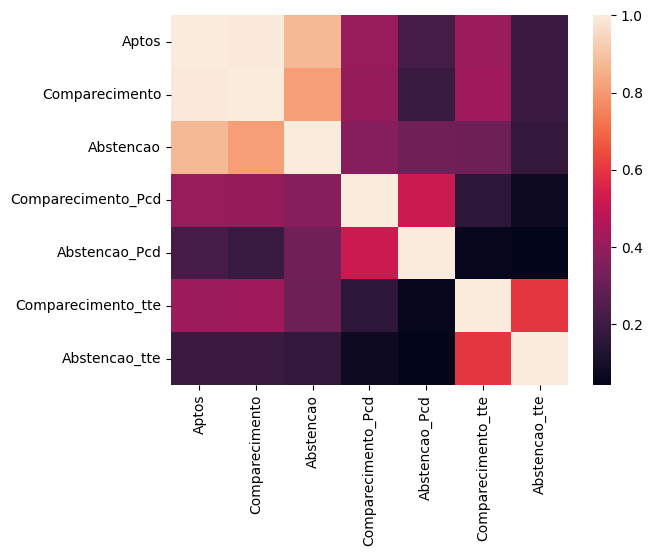

In [34]:
corr = tb_eleicoes.corr()
corr = (corr)
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)
corr

C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\3250113586.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tb_eleicoes.Abstencao, kde=False, color="g", ax=axes[0]).set_title('Abstenção')
C:\Users\usuario\AppData\Local\Temp\ipykernel_27364\3250113586.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

Text(0, 0.5, 'Aptos')

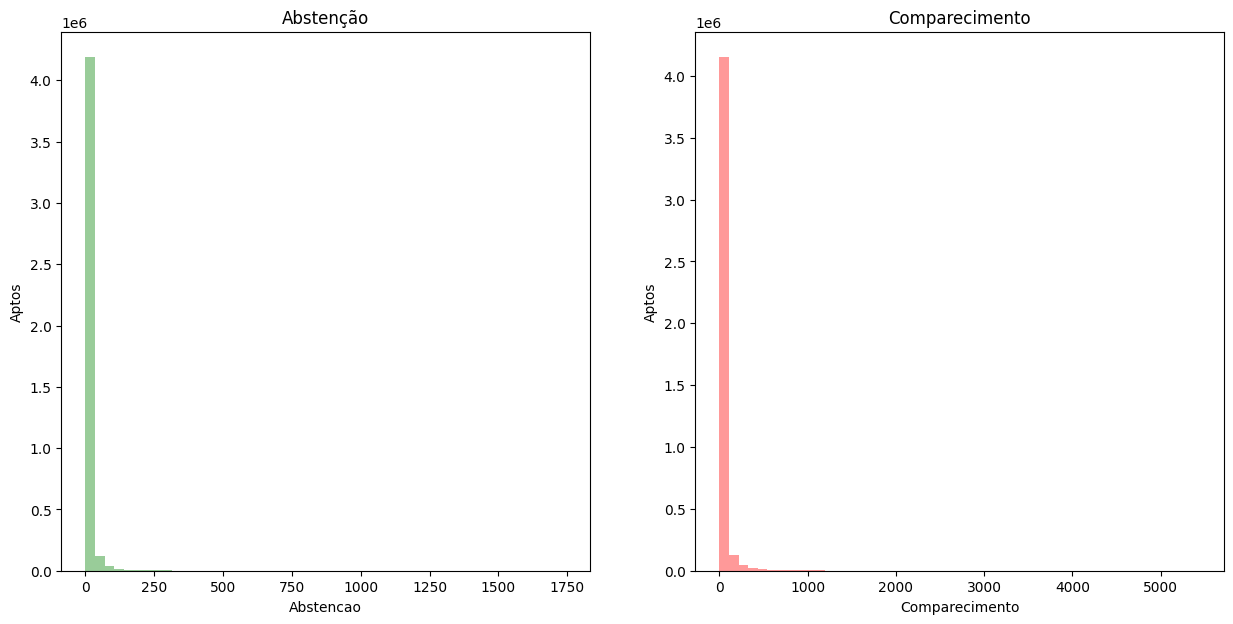

In [73]:
f, axes = plt.subplots(ncols=2, figsize=(15, 7))

sns.distplot(tb_eleicoes.Abstencao, kde=False, color="g", ax=axes[0]).set_title('Abstenção')
axes[0].set_ylabel('Aptos')

sns.distplot(tb_eleicoes.Comparecimento, kde=False, color="r", ax=axes[1]).set_title('Comparecimento')
axes[1].set_ylabel('Aptos')


In [79]:
kmeans = KMeans(n_clusters=3, random_state=2)

In [82]:
tb_eleicoes_turnover = tb_eleicoes[tb_eleicoes.Genero=="MASCULINO"][["Comparecimento","Abstencao","Comparecimento_Pcd","Abstencao_Pcd", "Comparecimento_tte", "Abstencao_tte"]]

In [83]:
kmeans.fit(tb_eleicoes_turnover)

KMeans(algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, random_state=2, tol=0.0001, verbose=0)

In [84]:
kmeans_colors = ['blue' if c == 0 else 'green' if c == 1 else 'red' for c in kmeans.labels_]

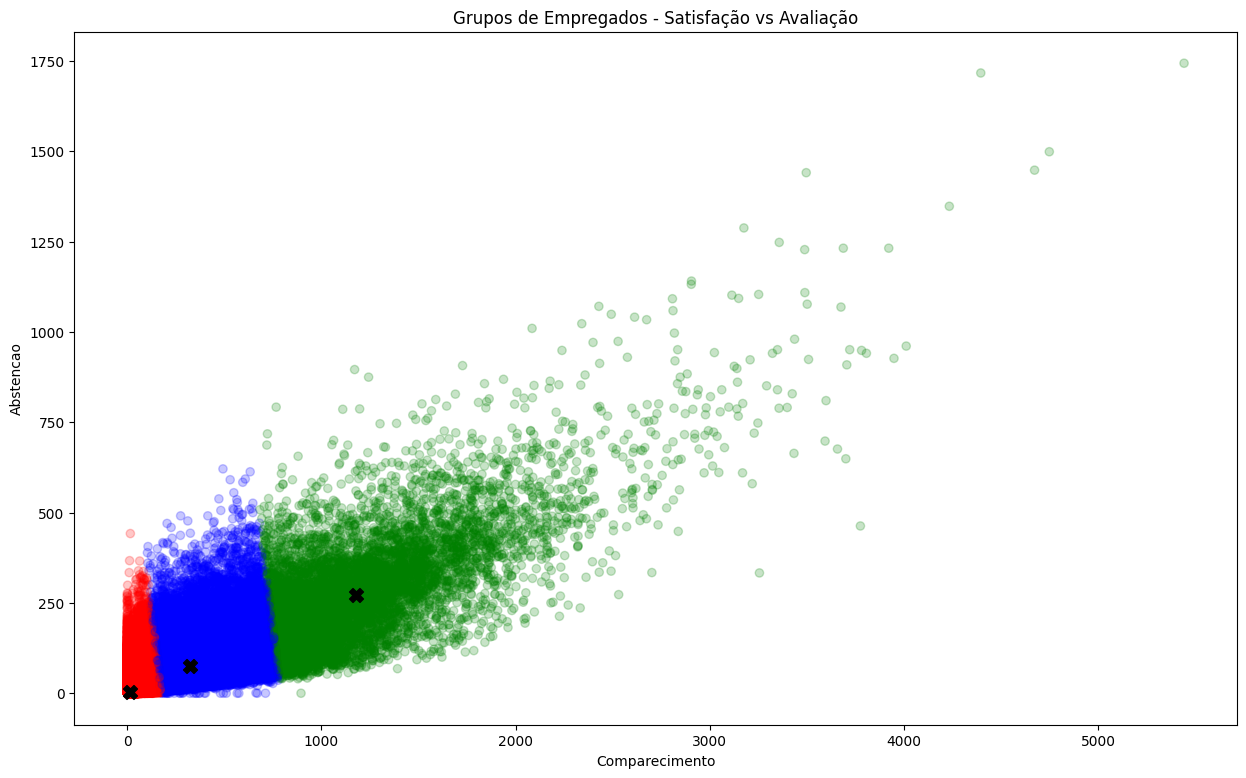

In [86]:
fig = plt.figure(figsize=(15, 9))
plt.scatter(
  x="Comparecimento",
  y="Abstencao",
  data=tb_eleicoes_turnover,
  alpha=0.22,
  color=kmeans_colors)

plt.xlabel("Comparecimento")
plt.ylabel("Abstencao")

plt.scatter(
  x=kmeans.cluster_centers_[:,0],
  y=kmeans.cluster_centers_[:,1],
  color="black",
  marker="X",
  s=100)

plt.title("Grupos de Empregados - Satisfação vs Avaliação")
plt.show()